In [2]:
from IPython.display import HTML
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# 3D Simulation

#### Motivation and rationale

This model makes an estimate of a world-state (i.e. a position, a velocity, or a fuel-level etc.) based on a set of previous measurements. At each moment, we incorporate a new set of measurements and consider where we have been previously. 

Taking the world-state to be our position in space for now, the model functions by considering:
    - A predicted movement.
    - A measured movement.

We weight (1) and (2) to arrive at an overall estimate for our position at each time-step. If our measurements are noisy and we know what type of motion is taking place, then we would prefer to rely on our predictions. By contrast, if our measurements are accurate then there is no need to rely on our predictions. 

A distinctive attribute of this model is that it is probabilistic - we express our position estimates in the form of probability distributions. We do this for two reasons:
    - Probability distributions can be combined in logically reasonable ways.
    - Distributional estimates preserve uncertainty about our path: A point estimate would throw away valuable information about alternative paths that we may have followed to arrive at our current position.

In the razor model, we do not estimate position alone at each time-step - we also make estimates of velocity and acceleration. By seeking the most likely values for these derivative quantities, we can estimate our position more accurately.

#### Algorithm

Algorithmically, the program does the following:

    1. Define a relationship between adjacent world-states. For example, assume the next position is equal to the current one plus the movement in that time, i.e.
$$
    \text{Current world-state velocity} = \text{Previous world state velocity} + \text{Previous world state acceleration}\cdot \Delta t
$$

    would correspond to our movement in velocity-space.
    
    2. Define a relationship between our measurements and world-state: if we are measuring linear acceleration and the sensor is unbiased, then we would use:
$$
    \text{Measured acceleration} = \text{World-state acceleration} + \text{Noise}
$$

    3. Define an initial world state (i.e. calibrate).
    
    4. After each time-step:
        1. Predict a set of current world-states based on the previous world state alone (use the relationship in Step 1).
        2. Determine what world-states would corroborate our measurements (use the relationship in Step 2).
        3. Return the world-state that is most likely based on both our prediction and measurements.
   
You may be wondering whether we can incorporate measurements 'from the future' to improve our position estimates. We can - and will - however for the purposes of this demo I wanted to keep the model simple.

#### Equations

Relationship between adjacent world states:
$$
    w_t = \Phi_p w_{t-1} + \text{Error}
$$
Relationship between world state and measured state:
$$
    x_t = \Phi_m w_t + \text{Noise}
$$

Both $\Phi_p$ and $\Phi_m$'s meanings are described below - they are simply matrices that we use to sum the appropriate velocities, accelerations, and displacements as per the physical laws.

By assuming that both the noise and the error are normally distributed r.v.s, we can derive equations that allow us to perform the weighting of predictions and measurements as described above. Assuming normality means that:
    1. We can quickly compute an updated world state (normal distributions are mathematically convenient).
    2. We can express uncertainty in our predicted world state and our measurements.
    
The update equations follow and are for my own reference - they are not important to understanding how the model works.

State prediction:
$$
    \mu_{+} = \mu_{p} + \Phi_{p}\mu_{t-1}
$$
Covariance prediction:
$$
    \Sigma_{+} = \Sigma_{p} + \Phi_{p}\Sigma_{t-1}\Phi_{p}^T
$$
Kalman gain:
$$
    K = \Sigma_{+}\Phi_m^T (\Sigma_m + \Phi_m \Sigma_{+} \Phi_m^T)^{-1}
$$
State update:
$$
    \mu_{t} = \mu_{+} + K(x_{t} - \mu_m - \Phi_m \mu_{+})
$$
Covariance update:
$$
    \Sigma_{t} = (I - K\Phi_m)\Sigma_{+}
$$

For the meaning of each variable please see the code spec. below. If you are interested in how these expressions are derived (they are not obvious) I can elaborate on them further.

In [4]:
"""
Data structures:

    dt      : (Scalar float)  Sensor sampling period.
    N       : (Scalar  int )  Number of datapoints gathered.
    
    mu      : (Matrix float)  Matrix containing most probable world states at each instant.
                              Rows correspond to [displacement_xyz, velocity_xyz, acceleration_xyz] at time R*dt.
                              [N rows x 9 columns]
    Sigma   : (Tensor float)  Stack of world state covariance matrices (i.e. uncertainty measures).
                              Dimensions 2 and 3 correspond to Var(w, w), first dimension is time index.
                              [N x 9 x 9]
                              
    Phi_p   : (Matrix float)  Describes relationship between adjacent world states.
                              [9 x 9]
    Sigma_p : (Matrix float)  Prediction covariance matrix - quantifies uncertainty in each dimension (displ., vel, acc.)
                              of the world state prediction based on the predeceeding world state.
                              [9 x 9]
                              
    Phi_m   : (Matrix float)  Describes relationship between world state and measurements.
                              [3 x 9]
    Sigma_m : (Matrix float)  Describes measurement noise (i.e. noise in each dimension + their correlations).
                              [3 x 3]
                              
    mu_x    : (Vector float)  Mean predicted world state, based on the last world-state alone.
                              [9]
    Sigma_x : (Matrix float)  Prediction covariance matrix (represents uncertainty in each prediction dimension)
                              [9 x 9]
                              
    K       : (Matrix float)  Kalman gain - weights measurements relative to predictions.
                              [9 x 9]
                              
    X       : (Matrix float)  Measurements - each row corresponds to one sample, x_t = [ax, ay, az].
                              [N x 3]
    W       : (Matrix float)  True simulated world states (i.e. where the blade actually is, how fast it is moving).
                              Rows are w_t.
                              [N x 9]
                              
    Variables that get updated are mu_x, Sigma_x, mu, Sigma, and K.

"""

'\nData structures:\n\n    dt      : (Scalar float)  Sensor sampling period.\n    N       : (Scalar  int )  Number of datapoints gathered.\n    \n    mu      : (Matrix float)  Matrix containing most probable world states at each instant.\n                              Rows correspond to [displacement_xyz, velocity_xyz, acceleration_xyz] at time R*dt.\n                              [N rows x 9 columns]\n    Sigma   : (Tensor float)  Stack of world state covariance matrices (i.e. uncertainty measures).\n                              Dimensions 2 and 3 correspond to Var(w, w), first dimension is time index.\n                              [N x 9 x 9]\n                              \n    Phi_p   : (Matrix float)  Describes relationship between adjacent world states.\n                              [9 x 9]\n    Sigma_p : (Matrix float)  Prediction covariance matrix - quantifies uncertainty in each dimension (displ., vel, acc.)\n                              of the world state prediction based

### 1. Simulate a path.

In [127]:
N   = 100  # Number of datapoints
dt  = 0.1 # Sampling period

# Generate a path
t  = np.linspace(0, 1.5*np.pi, N) # Path parameter
SF = 100 # To avoid working with tiny numbers

a = SF*np.array([np.cos(t), np.sin(t), np.sin(t)]).T # Acceleration vectors
v = np.zeros([N, 3])
s = np.zeros([N, 3])

for i in range(1, N):
    v[i, :] = v[i-1, :] + a[i-1, :]*dt
    s[i, :] = s[i-1, :] + (v[i, :] + v[i-1, :])*dt*0.5
    
W = np.concatenate([s, v, a], axis = 1) # Matrix of world states

### 2. Simulate an associated set of accelerometer measurements for this path.

In [128]:
NOISE_SD = 0.15
X        = W[:, -3:]*(1 + NOISE_SD*np.random.normal(loc = 0, scale = 1, size = [N, 3]))

# Use the measurements to directly estimate displacement and velocity
nv = np.zeros([N, 3])
ns = np.zeros([N, 3])

for i in range(1, N):
    nv[i, :]  = nv[i-1, :] + X[i-1, :]*dt
    ns[i, :]  = ns[i-1, :] + (nv[i, :] + nv[i-1, :])*dt*0.5

### 3. Configure the model parameters.

In [129]:
# Relationship between adjacent world states
Phi_p           = np.eye(9)
dt_ix           = (range(0, 6), range(3, 9))
dt_sq_ix        = (range(0, 3), range(6, 9))
Phi_p[dt_ix]    = dt
Phi_p[dt_sq_ix] = 0.5 * dt**2

In [131]:
pacc_sd  = 3*np.ones([3])
pvel_sd  = dt*pacc_sd*np.ones([3]) # MANUALLY TUNED
pdisp_sd = pvel_sd*dt*np.ones([3]) # MANUALLY TUNED
Sigma_p = np.diag(np.hstack([pdisp_sd, pvel_sd, pacc_sd])**2)

print(Sigma_p)

[[ 0.001  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.001  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.001  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.09   0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.09   0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.09   0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     9.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     9.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     9.   ]]


In [132]:
# Relationship between measurements and true world state
Phi_m           = np.zeros([3, 9])
Phi_m[0:3, 6:9] = np.eye(3) # Only retains the acceleration values (i.e. what we're measuring)

In [133]:
# Roughly estimate sensor noise
true_noise = np.std(X - np.matmul(W, Phi_m.T), axis = 0)
Sigma_m    = true_noise**2 * np.eye(3)
print(Sigma_m)

[[ 134.947    0.       0.   ]
 [   0.      75.048    0.   ]
 [   0.       0.      69.053]]


In [134]:
# Predicted world state + variances based on previous w.s. alone
mu_plus    = np.zeros([9, 1])
Sigma_plus = np.zeros([9, 9])

In [135]:
# World state estimates at each time step
mu    = np.zeros([N, 9])
Sigma = np.zeros([N, 9, 9])

# Calibrate the first value
mu[0, :]  = W[0, :]

### 4. Run the estimates.

In [136]:
def kalman_gain(Sigma_plus, Phi_m, Sigma_m):
    t1 = np.matmul(Sigma_plus, Phi_m.T)
    t2 = np.linalg.inv(Sigma_m + np.matmul(np.matmul(Phi_m, Sigma_plus), Phi_m.T))
    K  = np.matmul(t1, t2)
    return K

I = np.eye(9)

for t in range(1, N):
    # 1. Predict world state based on previous world state alone (prior).
    mu_plus    = np.matmul(Phi_p, mu[t-1, :])
    Sigma_plus = Sigma_p + np.matmul(np.matmul(Phi_p, Sigma[t-1, :, :]), Phi_p.T)
    
    # 2. Compute Kalman gain (measurement weighting).
    K = kalman_gain(Sigma_plus, Phi_m, Sigma_m)
    
    # 3. Combine measurements and prediction to form a final estimate for the current world state.
    mu[t, :]       = mu_plus + np.matmul(K, X[t, :] - np.matmul(Phi_m, mu_plus))
    Sigma[t, :, :] = np.matmul(I - np.matmul(K, Phi_m), Sigma_plus)

### 5. Visualize the results.

The improvement is most obvious in acceleration space.

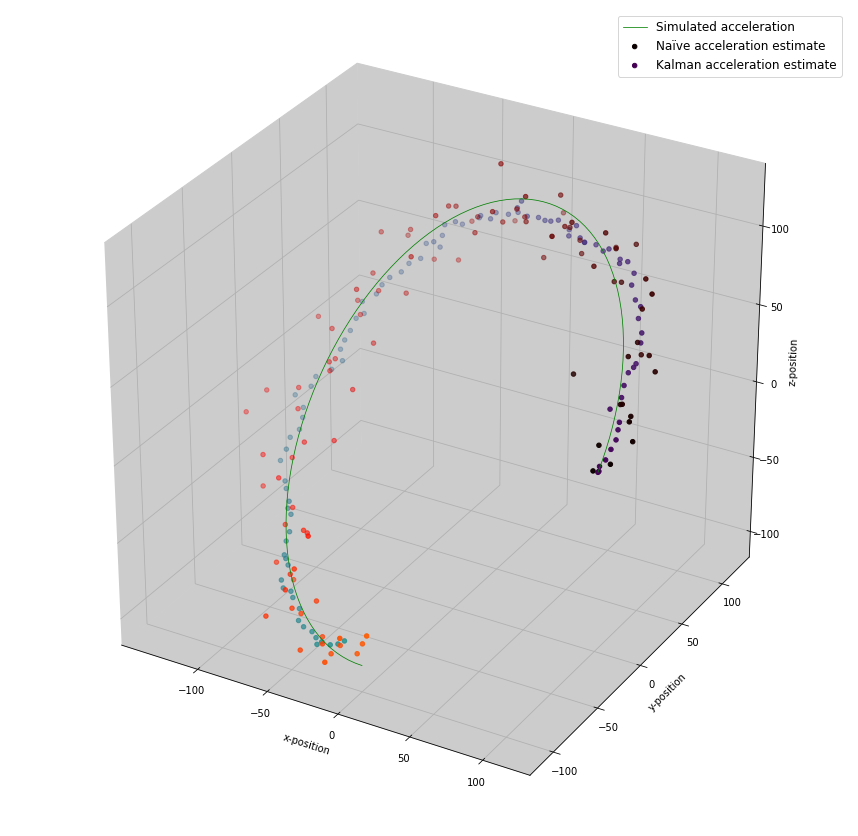

In [137]:
# Display the acceleration
fig = plt.figure(figsize = (15, 15))
ax  = fig.add_subplot(111, projection='3d')

ax.plot(a[:, 0], a[:, 1], a[:, 2],
        zdir='z',
        c = 'green', linewidth=0.75, label = 'Simulated acceleration')
ax.scatter(X[:, 0], X[:, 1], X[:, 2],
           zdir='z', s=20, depthshade=True,
           c = plt.cm.hot(np.linspace(0, 0.5, N)),
           label = 'Naïve acceleration estimate')
ax.scatter(mu[:, 6], mu[:, 7], mu[:, 8],
           zdir='z', s=20, depthshade=True,
           c = plt.cm.viridis(np.linspace(0, 0.5, N)),
           label = 'Kalman acceleration estimate')
ax.set_xlabel('x-position')
ax.set_ylabel('y-position')
ax.set_zlabel('z-position')

ax.legend(fontsize = 12);

plt.gca().patch.set_facecolor('white')
ax.w_xaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
ax.w_yaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))

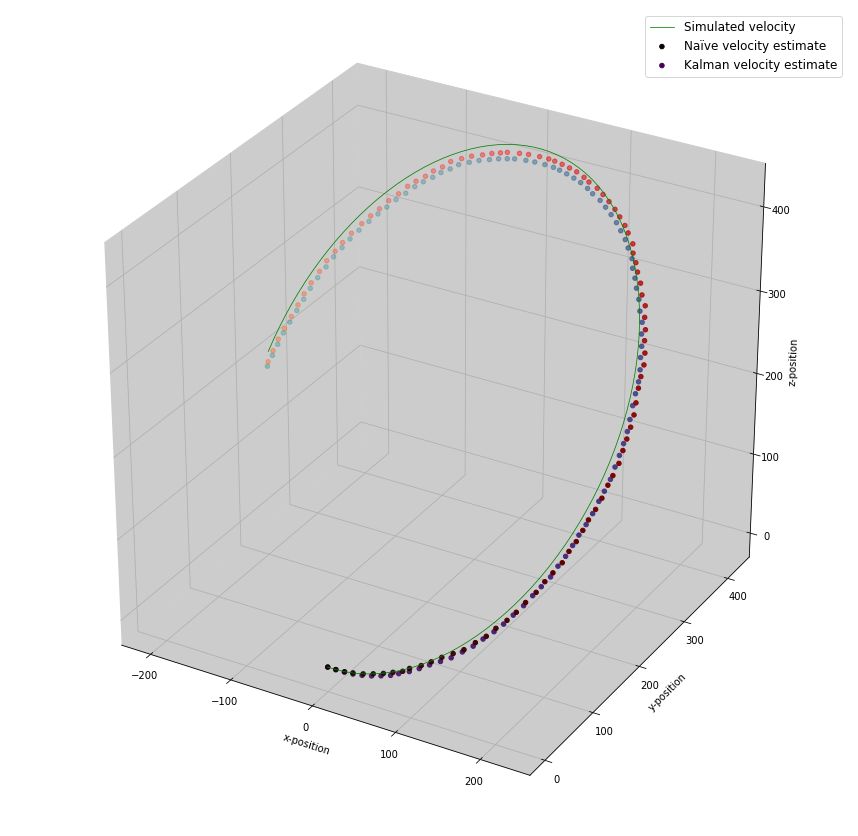

In [138]:
# Display the path
fig = plt.figure(figsize = (15, 15))
ax  = fig.add_subplot(111, projection='3d')

ax.plot(v[:, 0], v[:, 1], v[:, 2],
           zdir='z',
           c = 'green', linewidth=0.75, label = 'Simulated velocity')
ax.scatter(nv[:, 0], nv[:, 1], nv[:, 2],
           zdir='z', s=20, depthshade=True,
           c = plt.cm.hot(np.linspace(0, 0.5, N)),
           label = 'Naïve velocity estimate')
ax.scatter(mu[:, 3], mu[:, 4], mu[:, 5],
           zdir='z', s=20, depthshade=True,
           c = plt.cm.viridis(np.linspace(0, 0.5, N)),
           label = 'Kalman velocity estimate')
ax.set_xlabel('x-position')
ax.set_ylabel('y-position')
ax.set_zlabel('z-position')

ax.legend(fontsize = 12);

plt.gca().patch.set_facecolor('white')
ax.w_xaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
ax.w_yaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))

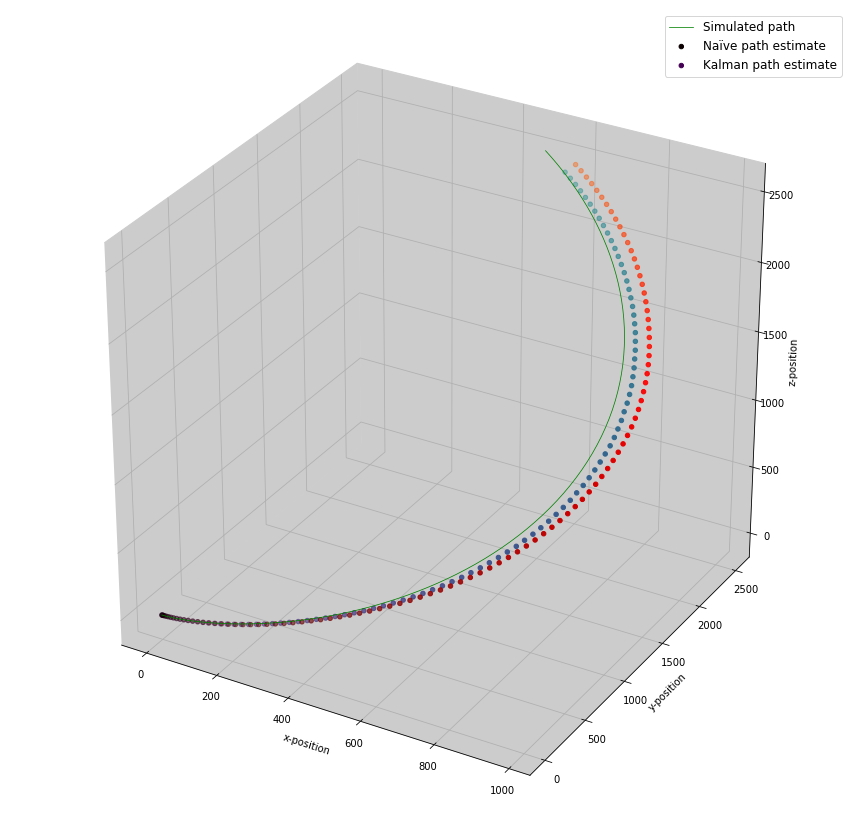

In [139]:
# Display the path
fig = plt.figure(figsize = (15, 15))
ax  = fig.add_subplot(111, projection='3d')

ax.plot(s[:, 0], s[:, 1], s[:, 2],
           zdir='z',
           c = 'green', linewidth=0.75, label = 'Simulated path')
ax.scatter(ns[:, 0], ns[:, 1], ns[:, 2],
           zdir='z', s=20, depthshade=True,
           c = plt.cm.hot(np.linspace(0, 0.5, N)),
           label = 'Naïve path estimate')
ax.scatter(mu[:, 0], mu[:, 1], mu[:, 2],
           zdir='z', s=20, depthshade=True,
           c = plt.cm.viridis(np.linspace(0, 0.5, N)),
           label = 'Kalman path estimate')
ax.set_xlabel('x-position')
ax.set_ylabel('y-position')
ax.set_zlabel('z-position')

ax.legend(fontsize = 12);

plt.gca().patch.set_facecolor('white')
ax.w_xaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
ax.w_yaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))

#### Displacement RSS

In [140]:
np.mean((W[:, :3] - ns[:, :3])**2) # Naive RSS

1481.7145135516068

In [141]:
np.mean((W[:, :3] - mu[:, :3])**2) # Kalman RSS

1712.0286205044486

#### Acceleration RSS

In [142]:
np.mean((W[:, -3:] - X[:, :])**2) # Naive RSS

94.469420794716541

In [143]:
np.mean((W[:, -3:] - mu[:, -3:])**2) # Kalman RSS

91.139296079912015